# Stochastic Processes/Time Series Exploration

**Motivation:** Bored in quarantine and stochastic processes are interesting.

**References:**
- \[1\] https://towardsdatascience.com/animated-visualization-of-random-walks-in-python-dc18f01ef15e

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import scipy as sp
import seaborn as sns

sns.set(style='whitegrid');

%matplotlib inline

<IPython.core.display.Javascript object>

## Simple Random Walk (1-dimensional)

In a [simple random walk](https://en.wikipedia.org/wiki/Stochastic_process#Random_walk), we take a stroll on the number line. We flip a coin each time we want to take a step. If it lands on heads, we move one unit in the +1 direction. If it lands on tails, we move one unit in the -1 direction. 

Formally, each of the $n$ coin flips, denoted as $X_1$, $X_2$, $\dots$, $X_n$, is a binary random variable. Instead of H and T, we'll equivalently use +1 and -1. Each coin flip is independent and identically distributed (i.i.d.) and follows the discrete probability distribution
$$
P(X_i = +1) = \frac12 \quad \quad P(X_i = -1) = \frac12
$$
which has mean and variance
$$
\mathrm{E}[X_i] = 0 \quad \quad \mathrm{Var}(X_i) = 1
$$

In [148]:
def random_walk(n, y0=0):
    if n <= 0 or not isinstance(n, int):
        raise ValueError('Must have positive number of steps.')
    
    step_sizes = np.array([-1, 1])

    steps = np.empty(n)
    steps[0] = y0  # Initial condition
    steps[1:] = np.random.choice(step_sizes, n-1)

    y = np.cumsum(steps)

    return y

<IPython.core.display.Javascript object>

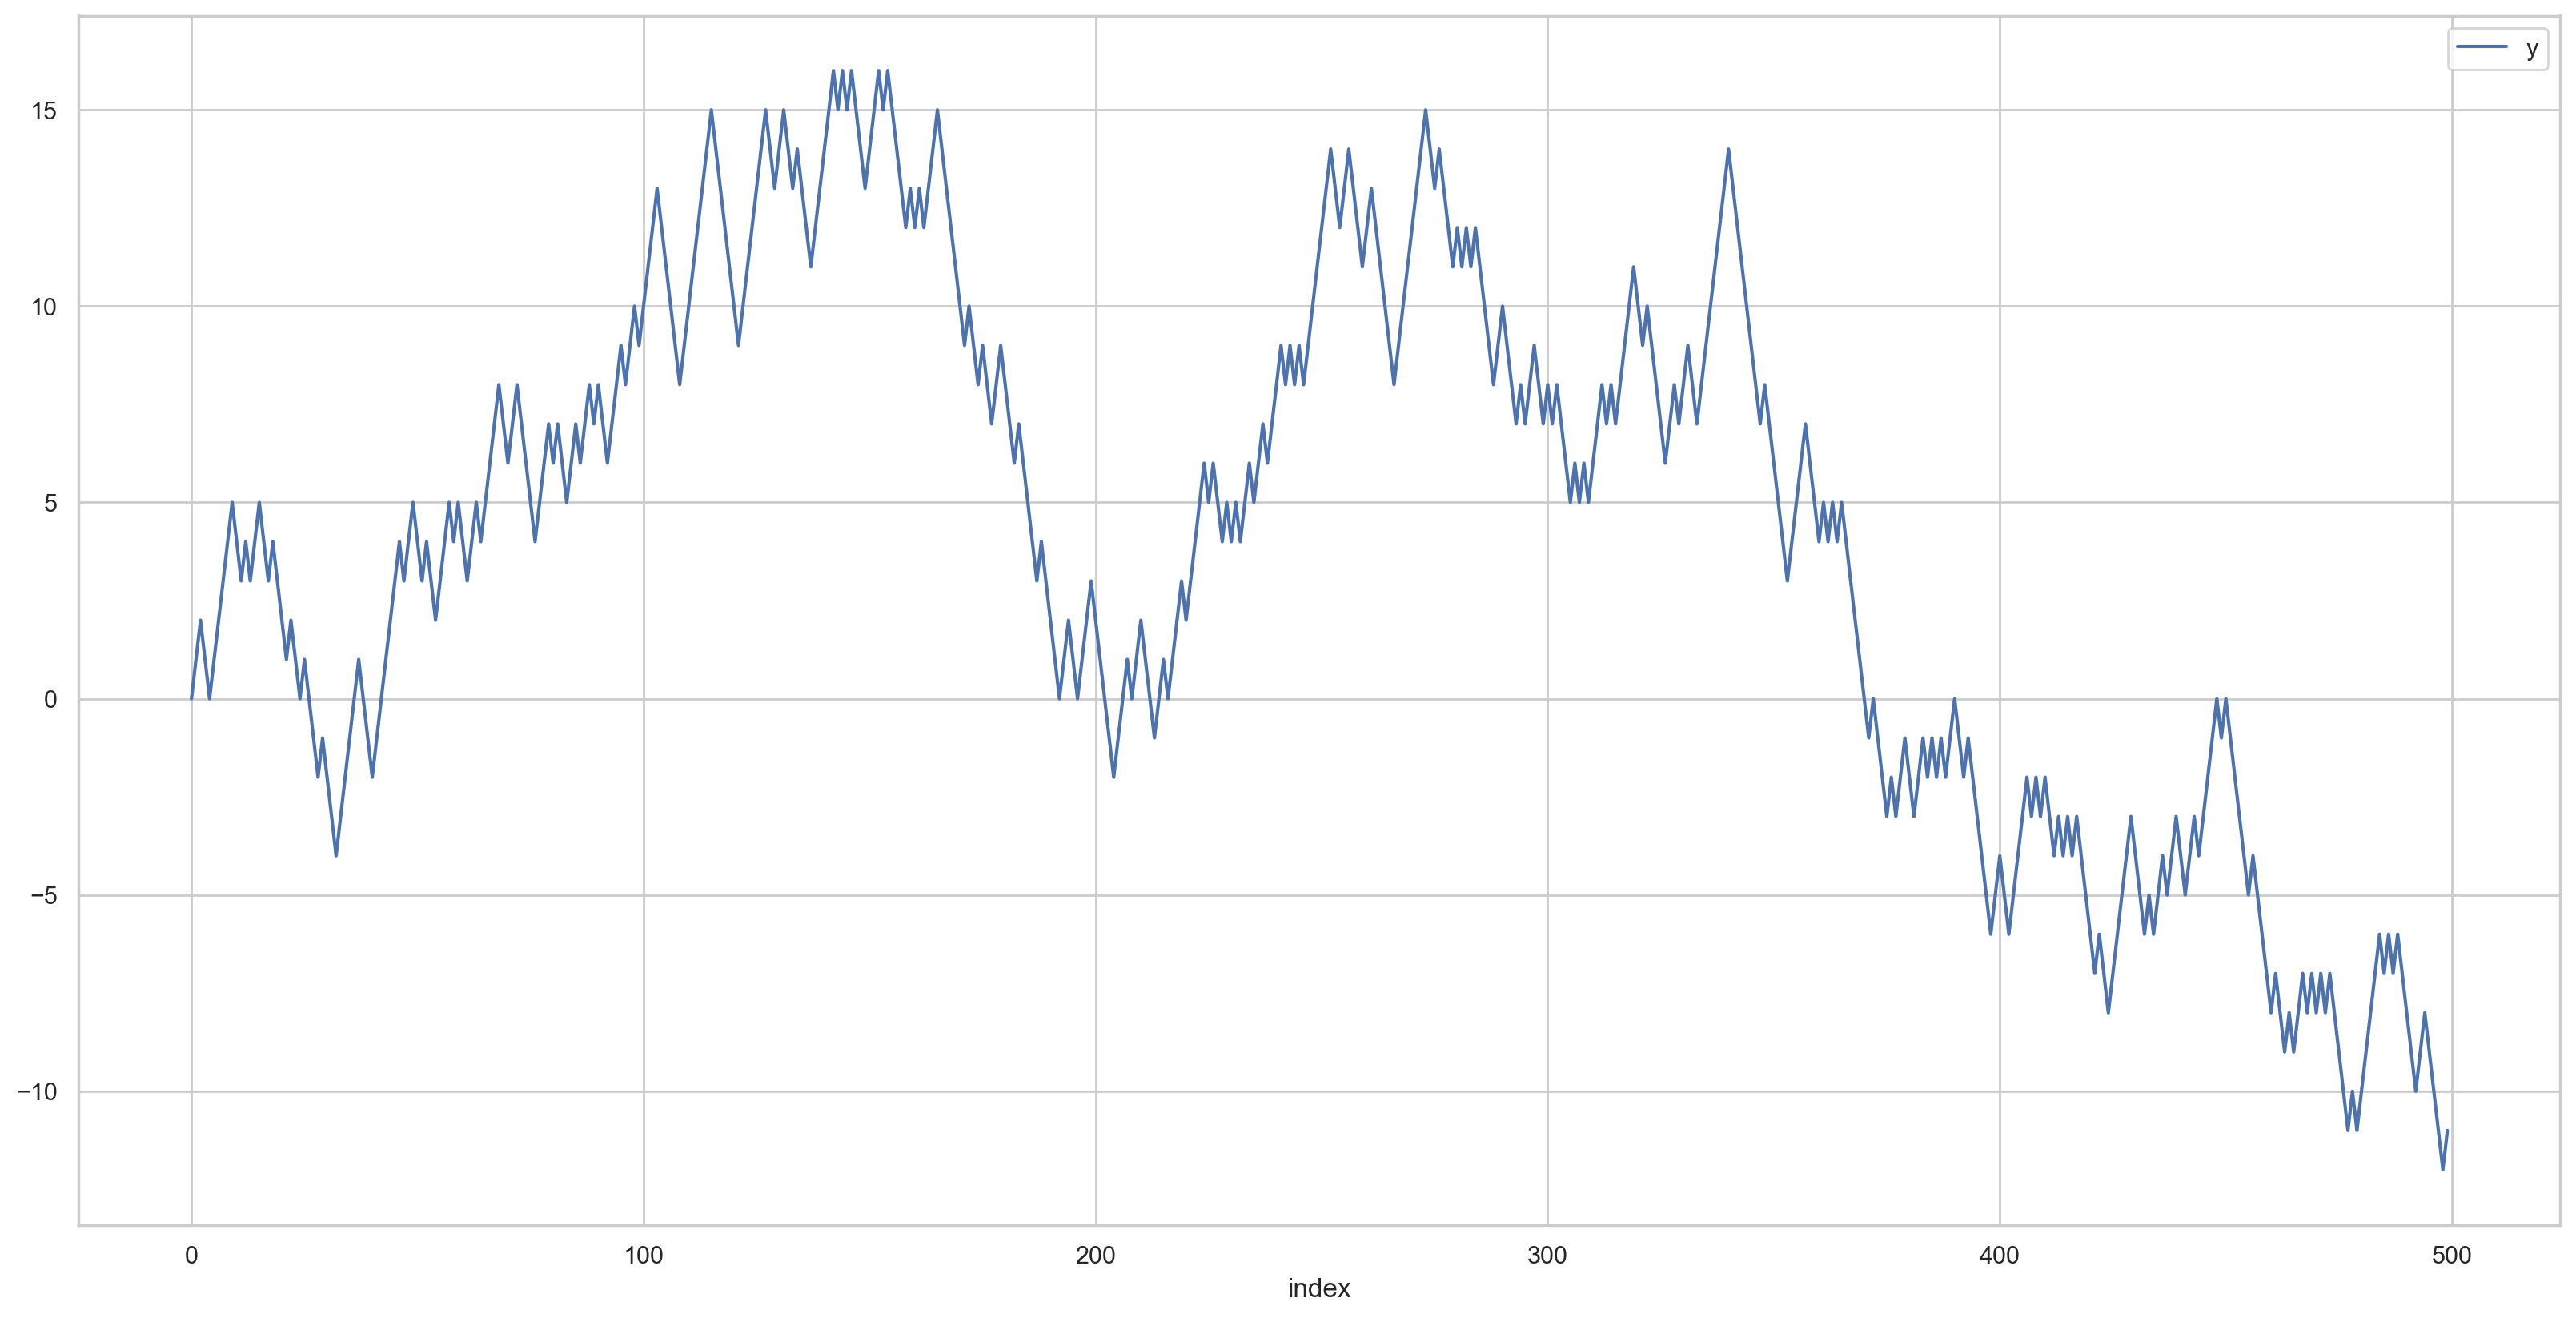

<IPython.core.display.Javascript object>

In [165]:
np.random.seed(1)

n = 500
x = np.arange(n)
y = random_walk(n)

fig, ax = plt.subplots(dpi=200, figsize=(20, 10))
rw = pd.DataFrame(data=y, columns=['y'], dtype='int64')
rw = rw.reset_index()  # Explicitly make index a labeled column
rw.plot(x='index', y='y', ax=ax);

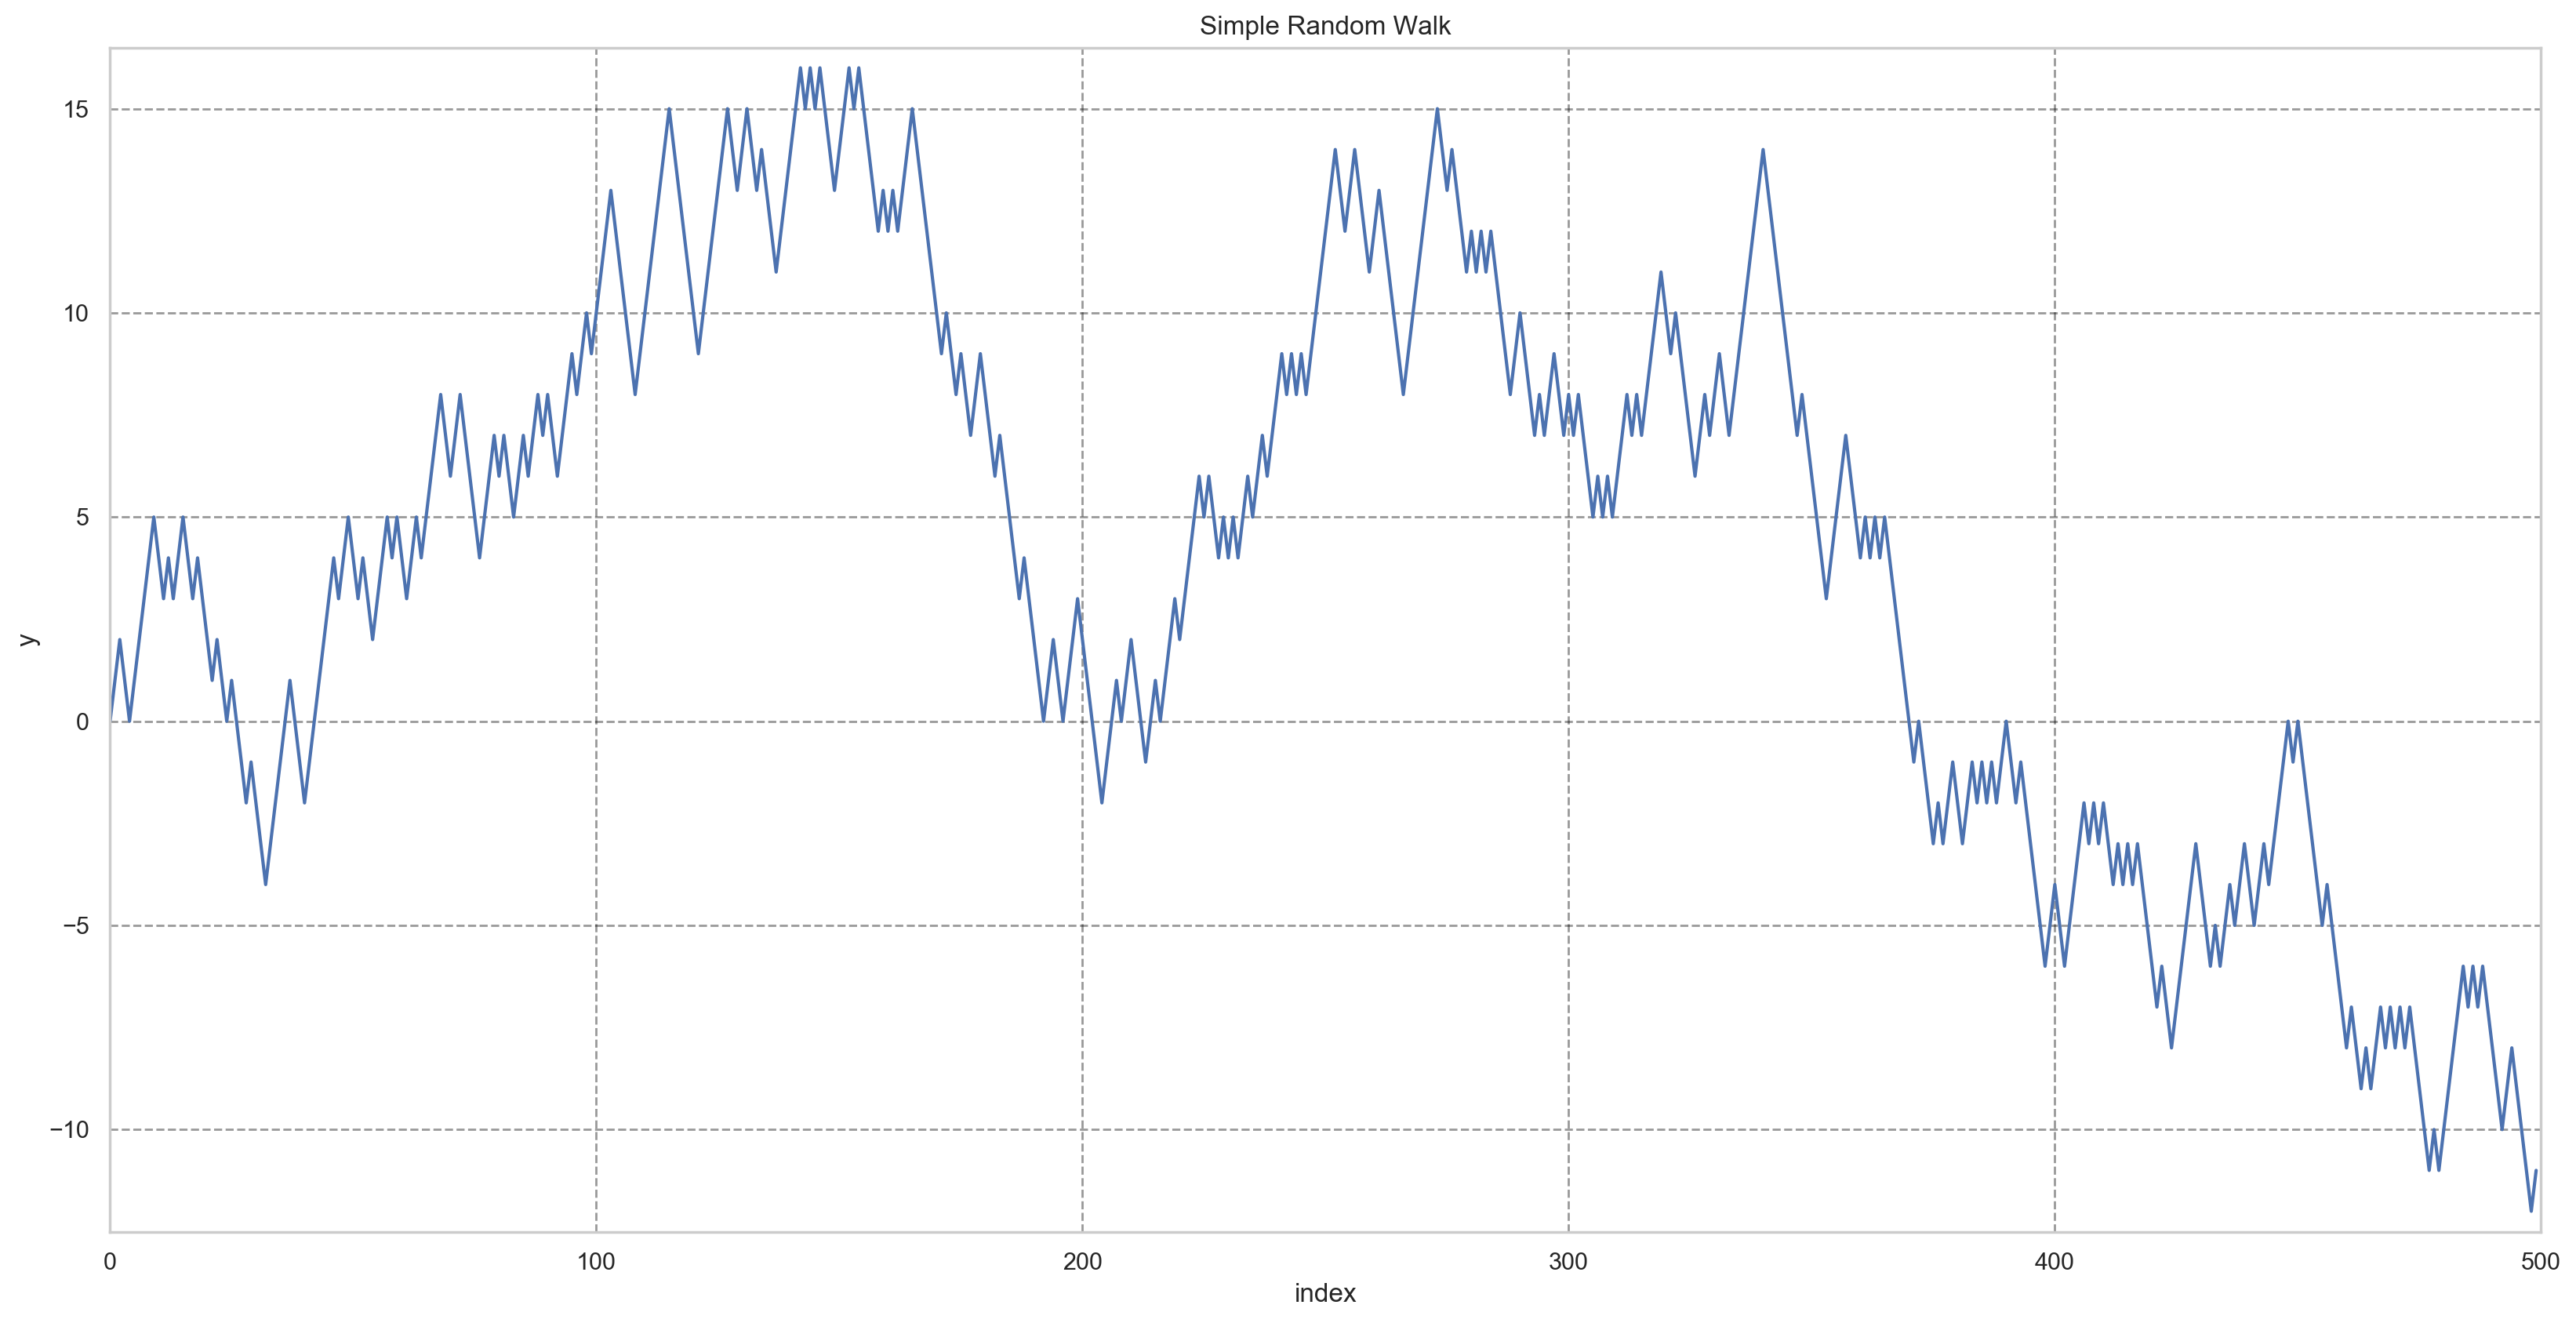

<IPython.core.display.Javascript object>

In [168]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)

fig, ax = plt.subplots(dpi=200, figsize=(20, 10))
line, = ax.plot([], [])
ax.set(
    xlabel='index',
    ylabel='y',
    title='Simple Random Walk',
    xlim=[0, n],
    ylim=[rw['y'].min() - 0.5, rw['y'].max() + 0.5]
)
ax.grid(True, which='major', linestyle='--', color='black', alpha=0.4)

def init():
    line.set_data([], [])
    return line,

def animate_rw(i):
    data = rw.iloc[:int(i+1)]
    xdata = data['index'].values
    ydata = data['y'].values
    line.set_data(xdata, ydata)
    return line,

anim = animation.FuncAnimation(fig, animate_rw, init_func=init, frames=n, interval=20, blit=True)
anim.save('random_walk.mp4', writer=writer)

### Some theoretical properties

After $n$ steps, our current location on the number line is determined by the sum of the steps taken so far. We denote our current position after $n$ steps as $S_n$, which is evaluated as
$$
S_n = \sum_{i = 1}^n X_i
$$
Since $S_n$ is a sum of random variables, then it is also a random variable. For large values of $n$, it is approximately normal
$$
S_n \rightarrow \mathcal{N}(0, n)
$$
or equivalently
$$
\frac{S_n}{\sqrt{n}} \rightarrow \mathcal{N}(0, 1)
$$
The [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) states that in the limit as $n \rightarrow \infty$, the above random variables are exactly normal.

### What does that mean?
If you did the random walk a bunch of times and recorded your final position after each random walk, then plotting all your recordings would show a curve that looks approximately normal.

If each of your random walks consisted of infinitely many steps, then the curve would be exactly normal, according to the CLT.

### Ties to Pascal's Triangle
The final position $S_n$ can be thought of as a mapping from length-$n$ coin flip sequences (e.g. HHHH...TTT, HTHH...THH, etc.) to the integers between $-n$ and $n$, inclusive. For the final position of $S_n = n$, there is only one sequence which gets us there -- the sequence of only heads. For the final position of $S_n = n-1$, there are $\binom{n}{1}$ sequences which get us there -- sequences with mostly heads and one tail somewhere.

In [155]:
np.random.seed(1)

num_trials = 1000
n = 500

final_positions = np.empty(num_trials)
for i in range(num_trials):
    y = random_walk(n)
    final_positions[i] = y[-1] / np.sqrt(n)

<IPython.core.display.Javascript object>

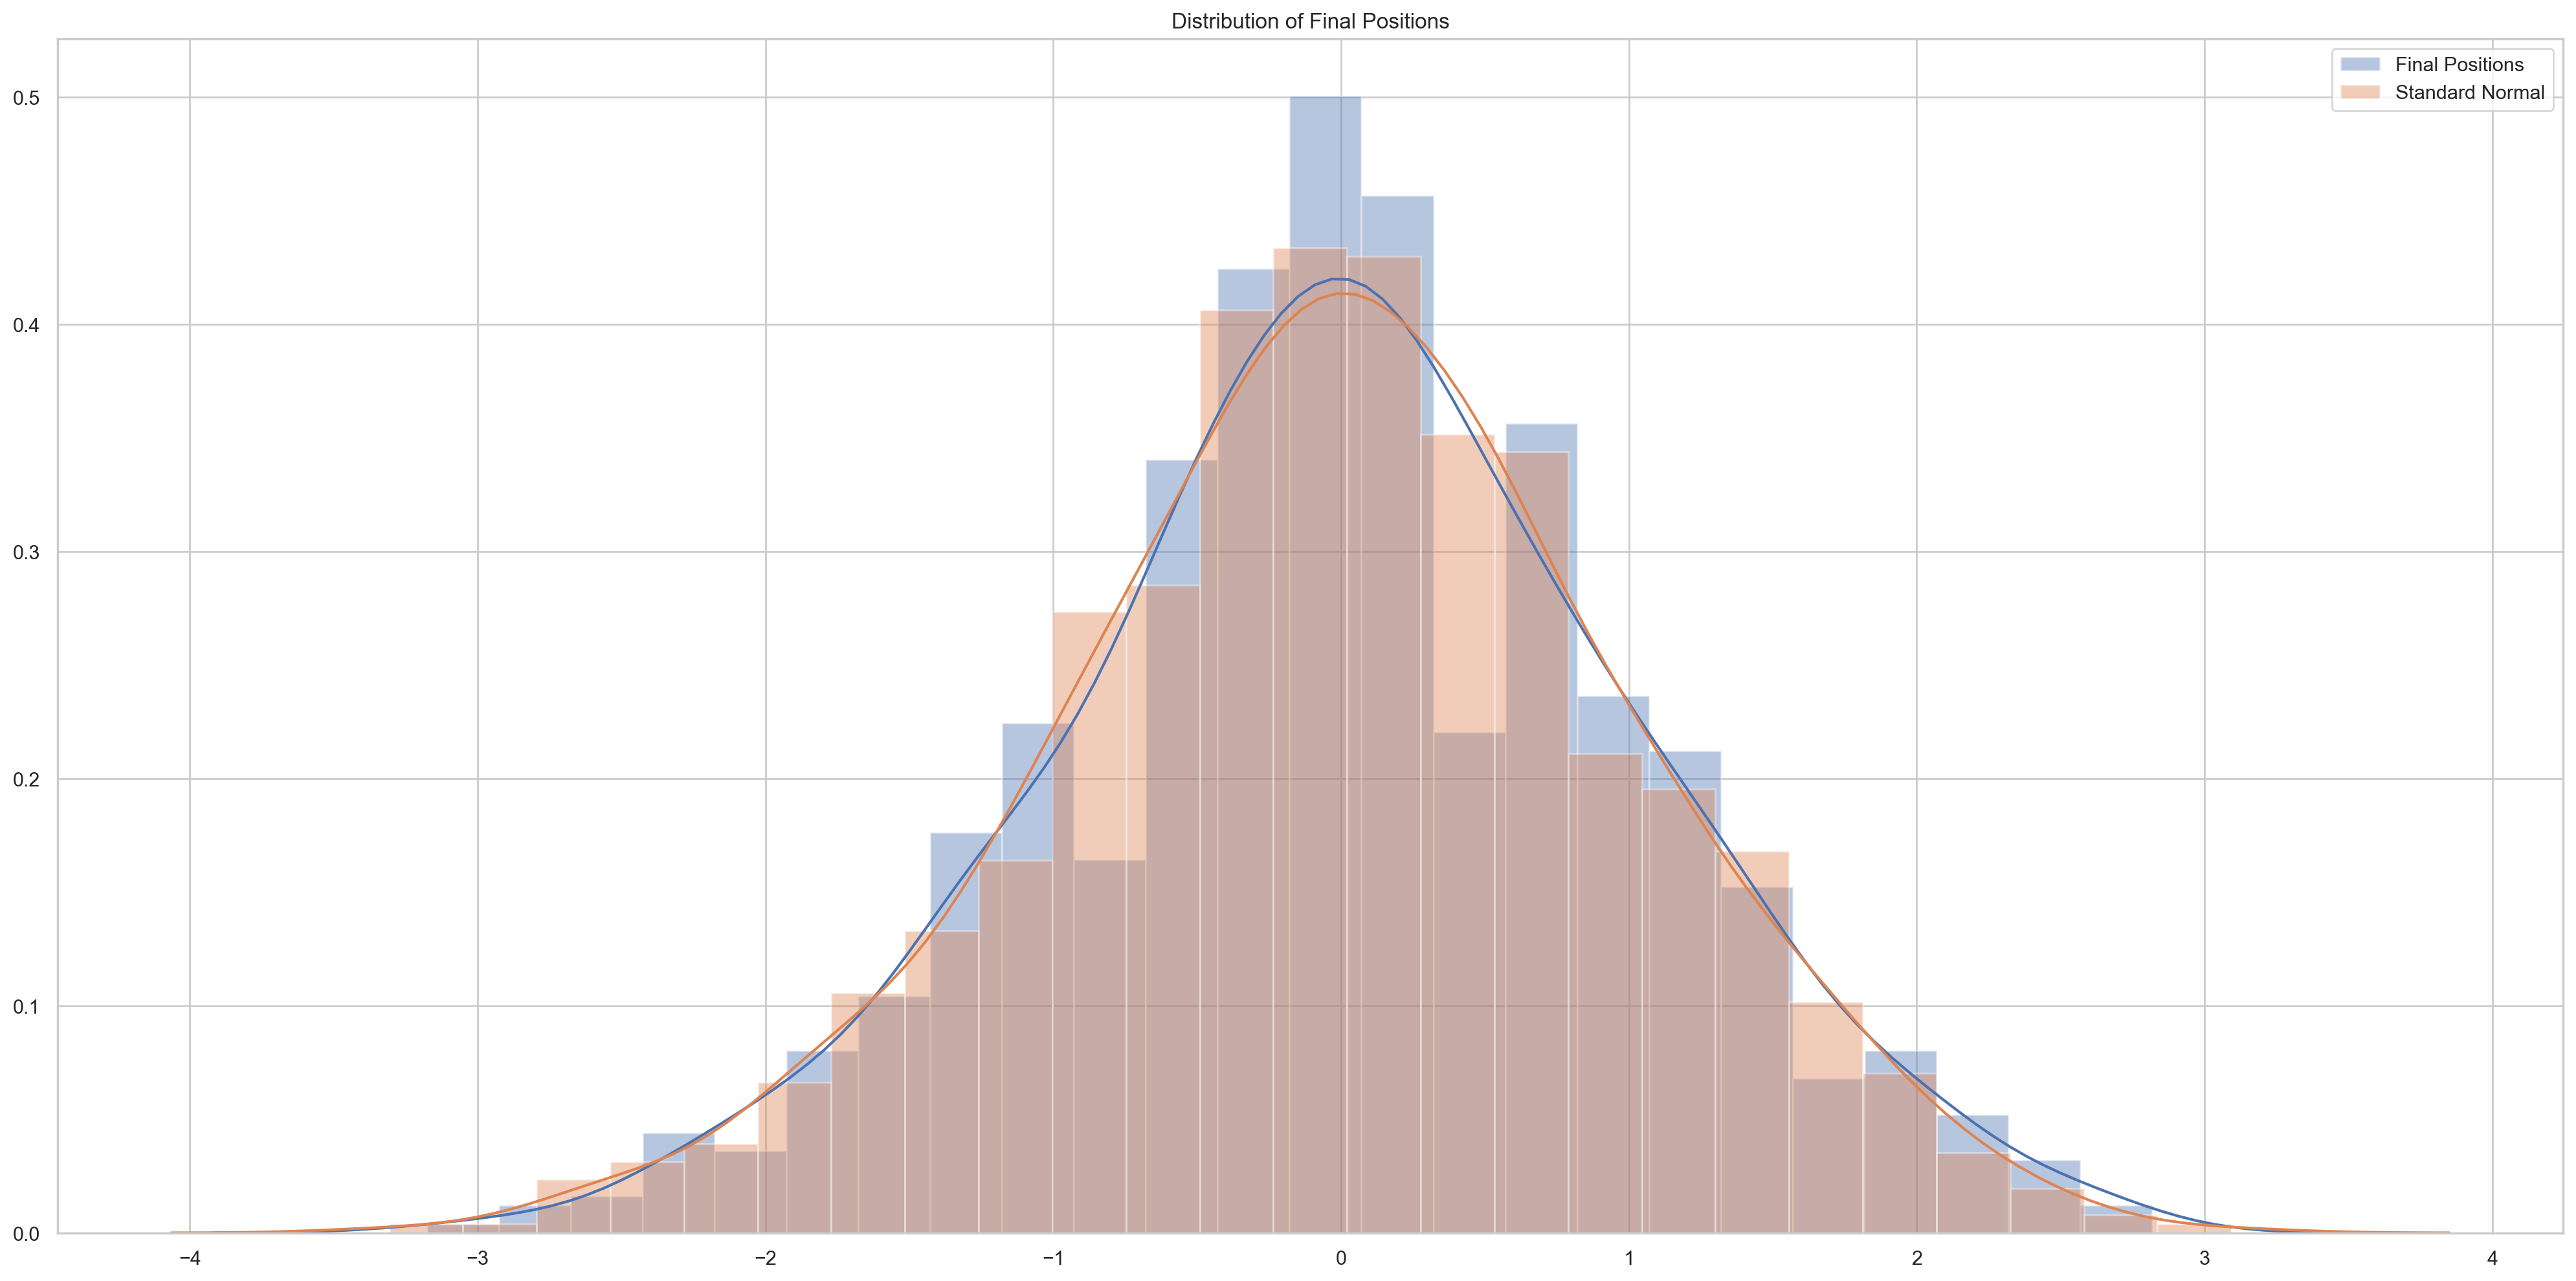

<IPython.core.display.Javascript object>

In [164]:
fig, ax = plt.subplots(dpi=200, figsize=(20, 10))
sns.distplot(final_positions, ax=ax, label='Final Positions')
sns.distplot(np.random.randn(num_trials), ax=ax, label='Standard Normal')
ax.set(title='Distribution of Final Positions')
ax.legend()
fig.tight_layout();

## Simple Random Walk (2-dimensional)

Now rather than just walking along the number line, suppose we walk in a coordinate grid. We randomly move one unit up, down, left, or right with equal probability.

Formally, instead of univariate random variables for each of our steps, we now have random vectors $\overset{\rightharpoonup}{X_i}$ of 2 elements, each of which follows the discrete probability distribution
$$
P\left(\overset{\rightharpoonup}{X_i} = \begin{bmatrix}1 \\ 0\end{bmatrix}\right) = \frac14 \quad \quad
P\left(\overset{\rightharpoonup}{X_i} = \begin{bmatrix}-1 \\ 0\end{bmatrix}\right) = \frac14 \quad \quad
P\left(\overset{\rightharpoonup}{X_i} = \begin{bmatrix}0 \\ 1\end{bmatrix}\right) = \frac14 \quad \quad
P\left(\overset{\rightharpoonup}{X_i} = \begin{bmatrix}0 \\ -1\end{bmatrix}\right) = \frac14
$$
with mean and covariance matrix
$$
\mathrm{E}[\overset{\rightharpoonup}{X_i}] = \overset{\rightharpoonup}{0} \quad \quad
\mathrm{Cov(\overset{\rightharpoonup}{X_i})} = \begin{bmatrix} 1/2 & 0 \\ 0 & 1/2 \end{bmatrix}
$$

In [166]:
def random_walk2d(n, x0=0, y0=0):
    if n <= 0 or not isinstance(n, int):
        raise ValueError('Must have positive number of steps.')
    
    steps = np.empty((n, 2))
    step_sizes = np.array([[1, 0],
                           [-1, 0],
                           [0, 1],
                           [0, -1]])
    
    steps[0] = [x0, y0]
    steps[1:] = step_sizes[np.random.choice(len(step_sizes), n-1)]

    coords = np.cumsum(steps, axis=0)
    x = coords[:, 0]
    y = coords[:, 1]
    
    return x, y

<IPython.core.display.Javascript object>

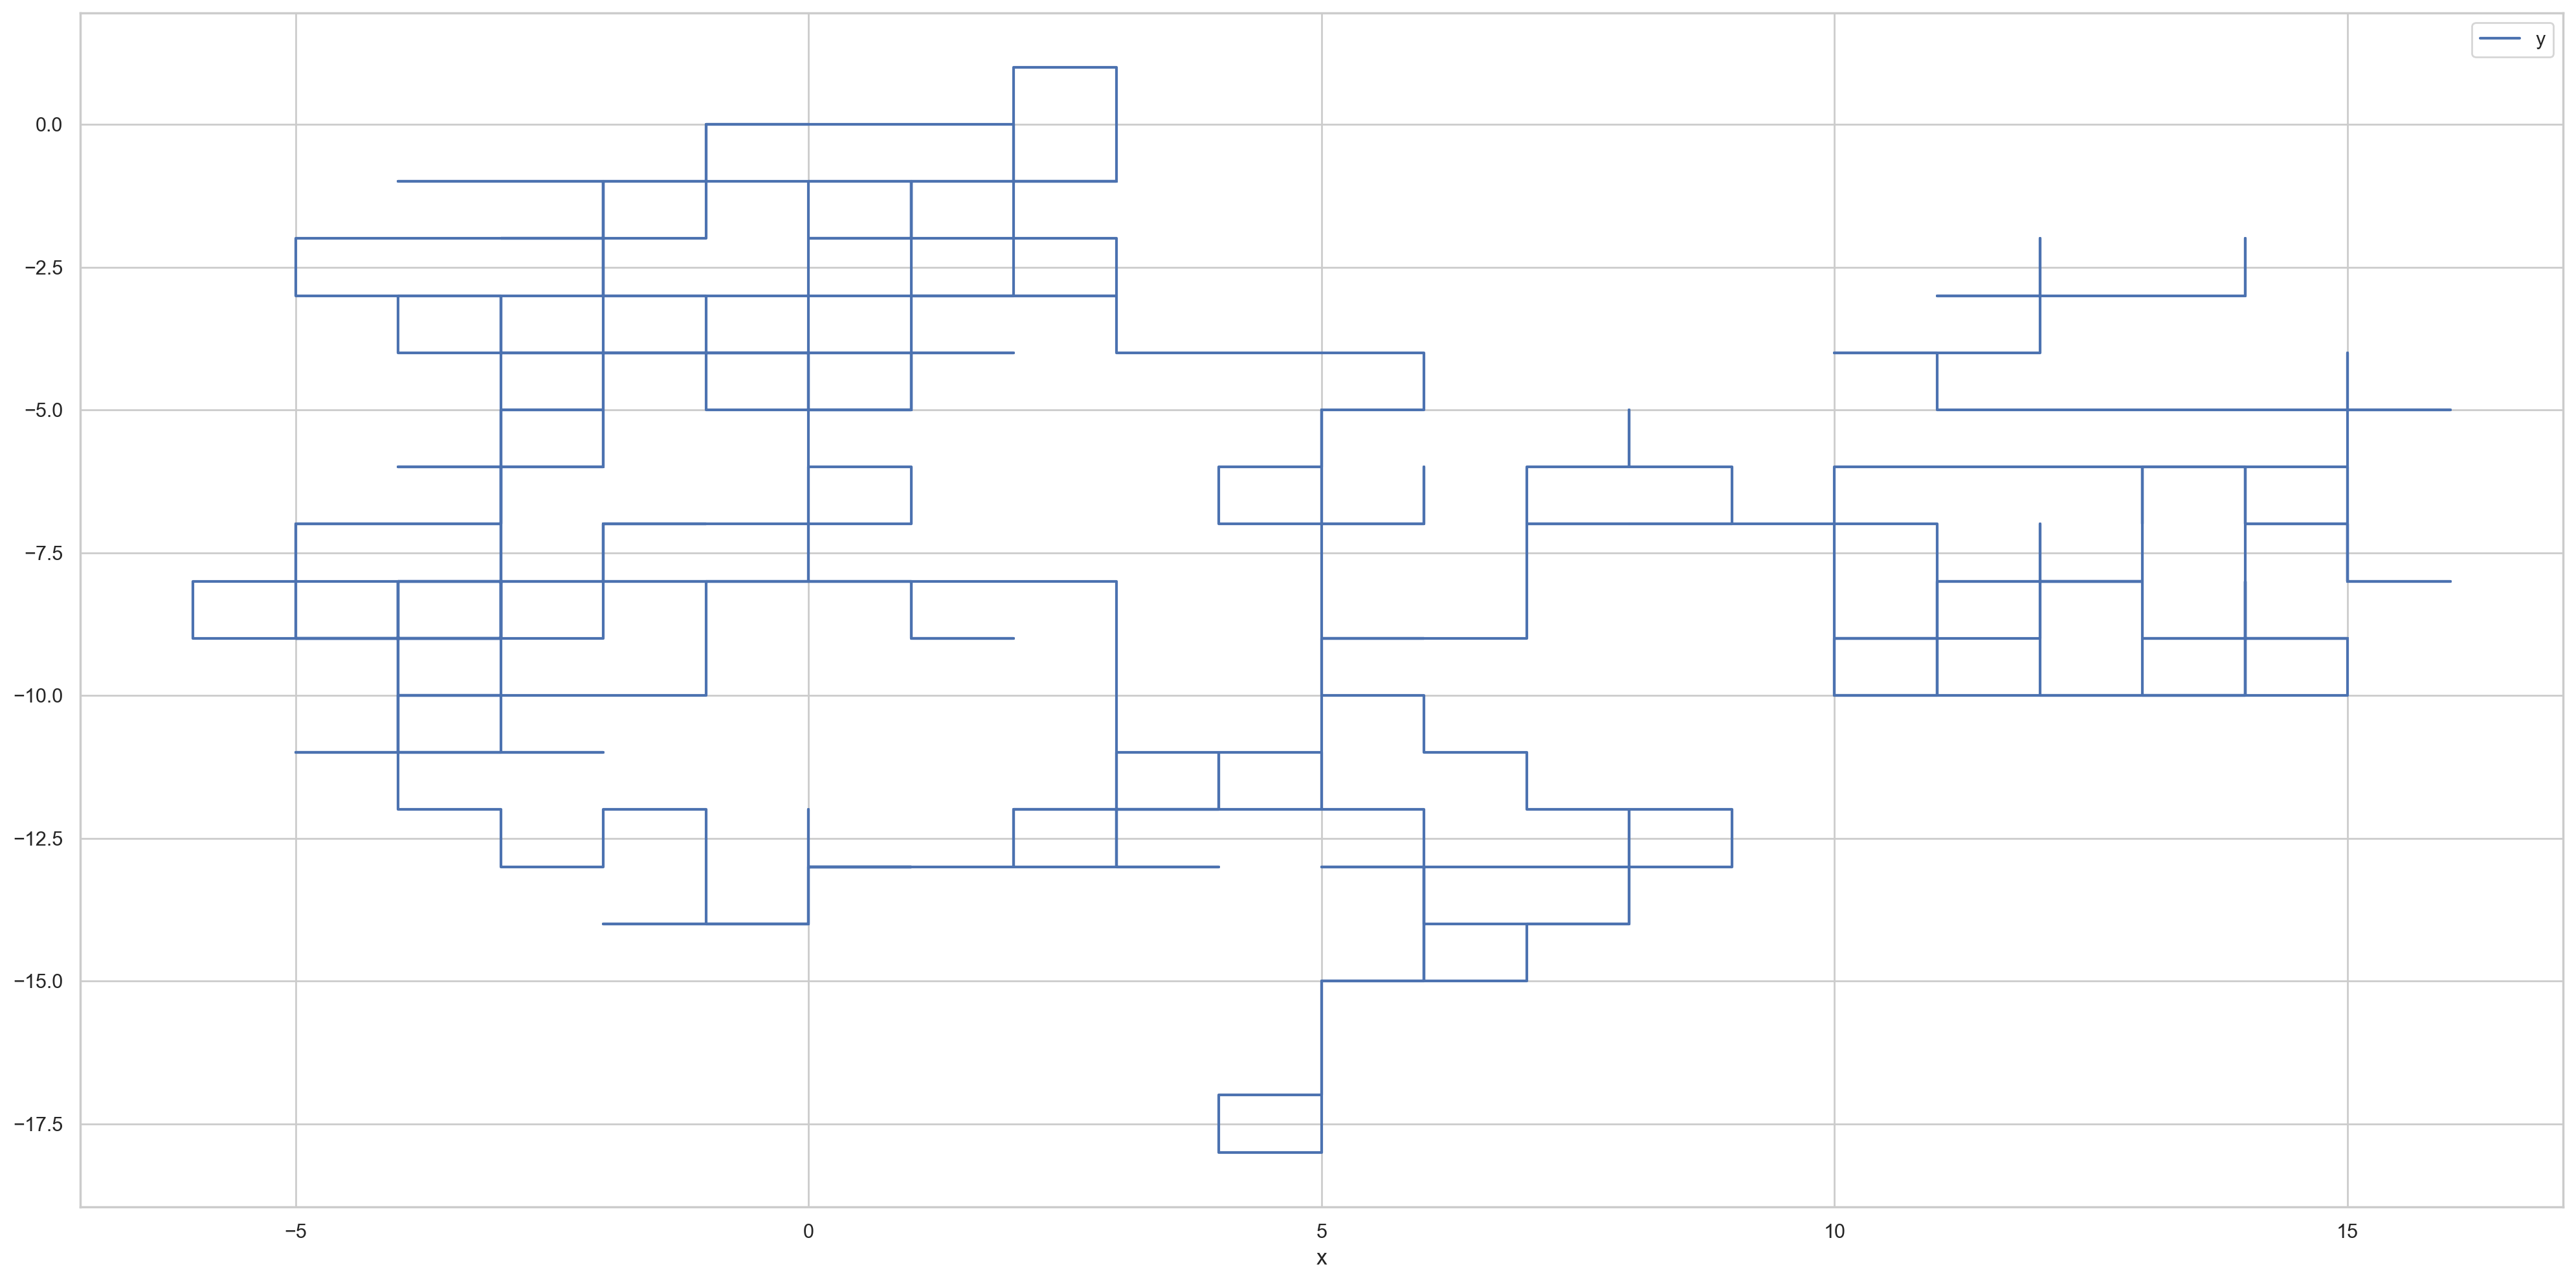

<IPython.core.display.Javascript object>

In [163]:
np.random.seed(1)

n = 500
i = np.arange(n)
x, y = random_walk2d(n)
coords = np.vstack([x, y]).T

fig, ax = plt.subplots(dpi=200, figsize=(20, 10))

rw2d = pd.DataFrame(data=coords, columns=['x', 'y'], dtype='int64')
rw2d = rw2d.reset_index()  # Explicitly make index a labeled column
rw2d.plot(x='x', y='y', ax=ax)
fig.tight_layout();

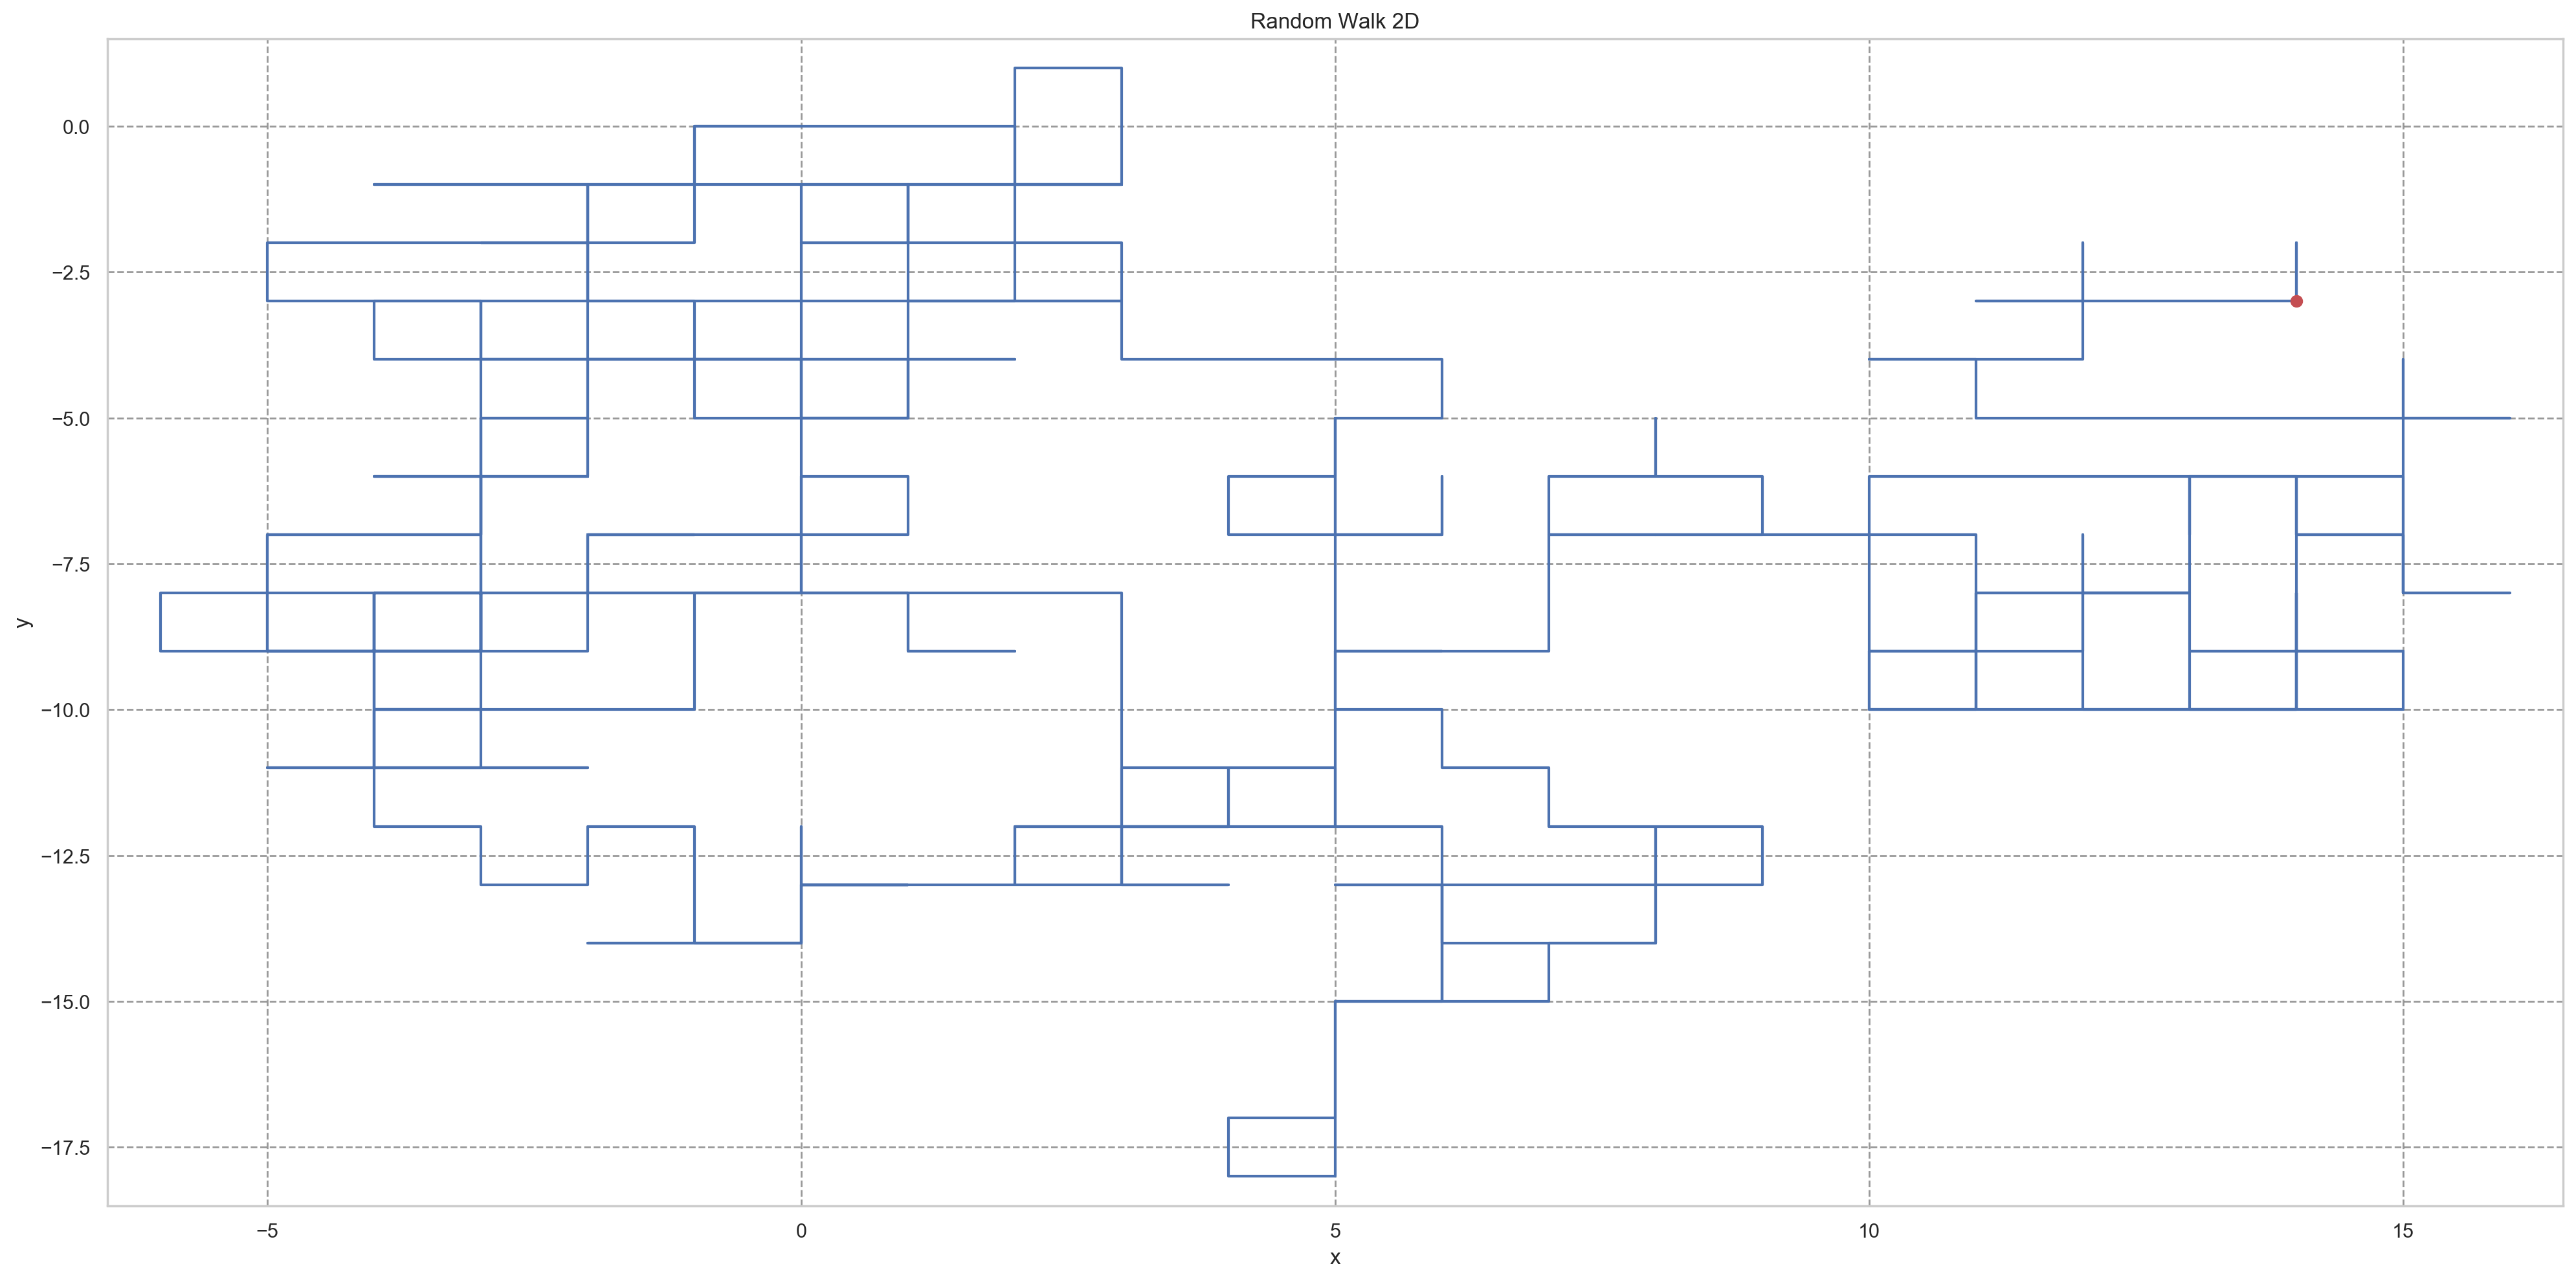

<IPython.core.display.Javascript object>

In [167]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)

fig, ax = plt.subplots(dpi=200, figsize=(20, 10))
line, = ax.plot([], [])
red_dot, = ax.plot(rw2d['x'][0], rw2d['y'][0], 'ro')
ax.set(
    xlabel='x',
    ylabel='y',
    title='Random Walk 2D',
    xlim=[rw2d['x'].min() - 0.5, rw2d['x'].max() + 0.5],
    ylim=[rw2d['y'].min() - 0.5, rw2d['y'].max() + 0.5],
)
ax.grid(True, which='major', linestyle='--', color='black', alpha=0.4)

def init():
    line.set_data([], [])
    return line,

def animate_rw2d(i):
    data = rw2d.iloc[:int(i+1)]
    xdata = data['x'].values
    ydata = data['y'].values
    line.set_data(xdata, ydata)
    red_dot.set_data(data['x'][i], data['y'][i])
    return line, red_dot

anim = animation.FuncAnimation(fig, animate_rw2d, init_func=init, frames=n, interval=20, blit=True)
anim.save('random_walk2d.mp4', writer=writer)
fig.tight_layout();